In [1]:
from google.colab import drive
drive.mount("/content/drive/")

Mounted at /content/drive/


In [9]:
import os
from PIL import Image
import torch
import torchvision.transforms.functional as TF

def read_image(image_path):
    """Reads an image from the given path and returns a PIL Image."""
    return Image.open(image_path).convert("RGB")

def get_scared_file_pairs(root_path):
    """
    Gets all the data, the right and left image from all dataset. the drive
    """
    left_images = []
    right_images = []

    for dataset_folder in sorted(os.listdir(root_path)):
        print(dataset_folder)
        dataset_path = os.path.join(root_path, dataset_folder)
        print(dataset_path)
        if not os.path.isdir(dataset_path):
          print('Not found')
          continue
        for keyframe_folder in sorted(os.listdir(dataset_path)):
            print("keyframe " +keyframe_folder)
            keyframe_path = os.path.join(dataset_path, keyframe_folder, 'rectified_video_frame')
            print(keyframe_path)
            if not os.path.isdir(keyframe_path):
              print('Not found')
              continue

            left_dir = os.path.join(keyframe_path, 'left')
            right_dir = os.path.join(keyframe_path, 'right')
            print(left_dir)

            for filename in sorted(os.listdir(left_dir)):
                  left_path = os.path.join(left_dir, filename)
                  left_images.append(left_path)
            for filename in sorted(os.listdir(right_dir)):
                  right_path = os.path.join(right_dir, filename)
                  right_images.append(right_path)

    return left_images, right_images

In [10]:
# SCARED_IGEV.py
#Cargar las imagenes rectificadas para ser procesadas por el modelo IGEV++
#The following code is going to handle Data Loading, Data Pre-Procesing for Traing or Evaluation and Data Augmentation.
#The paper set the image size to [256,320]

import os
import random
import torch
from torch.utils.data import Dataset
from torchvision import transforms
from torchvision.transforms import functional as F
#import scared_utils the function get_scared_file_pairs and read_images

class RandomFlip:
    """Random horizontal or vertical flip"""
    def __init__(self, horizontal=True, vertical=True):
        self.horizontal = horizontal
        self.vertical = vertical

    def __call__(self, img):
        if self.horizontal and random.random() < 0.5:
            img = F.hflip(img)
        if self.vertical and random.random() < 0.5:
            img = F.vflip(img)
        return img

class SCARED_IGEV(Dataset):
    def __init__(self, root_path, training=True):
        """
        Args:
            root_path (str): Root path to the SCARED dataset.
            training (bool): Whether the dataset is for training or evaluation.
        """
        self.training = training
        self.left_paths, self.right_paths = get_scared_file_pairs(root_path)


        self.transform_base  = transforms.Compose([
            transforms.Resize((256, 320)),
            transforms.ToTensor()
        ])
        self.transform_train  = transforms.Compose([
            RandomFlip(horizontal=True, vertical=True),
            transforms.ColorJitter(
                brightness=(0.8, 1.4),
                contrast=(0.8, 1.4),
                saturation=(0.8, 1.4),
                hue=(-0.1, 0.1)
            )
        ])
        """
        self.normalize = transforms.Normalize(
            mean=[0.485, 0.456, 0.406],  # ImageNet mean
            std=[0.229, 0.224, 0.225]
        )
        """

    def __len__(self):
        return len(self.left_paths)

    def __getitem__(self, idx):
        left_img = read_image(self.left_paths[idx])
        right_img = read_image(self.right_paths[idx])

        # Apply base transforms
        left_tensor = self.transform_base(left_img)
        right_tensor = self.transform_base(right_img)

        if self.training:

            left_aug = left_tensor.clone()
            left_aug = self.transform_train(left_aug)
            return left_aug, left_tensor, right_tensor

        else:

            left_aug = left_tensor.clone()
            return left_aug, left_tensor, right_tensor


In [23]:
from torch.utils.data import DataLoader, random_split

def get_scared_dataloader(args, train=True):

    dataset = SCARED_IGEV(args.data_path, training=train)

    total_size = len(dataset)
    train_size = int(0.70 * total_size)
    val_size = total_size - train_size

    train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

    train_loader = DataLoader(
        train_dataset,
        batch_size=args.batch_size,
        shuffle=True,
        num_workers=4,
        drop_last=True
    )

    val_loader = DataLoader(
        val_dataset,
        batch_size=args.batch_size_evaluation,
        shuffle=False,
        num_workers=4,
        drop_last=False
    )

    return train_loader, val_loader, total_size

In [24]:
class Args:
    data_path = '/content/drive/MyDrive/PROYECTO_ENDOSCOPIA/train/'
    batch_size = 10
    batch_size_evaluation = 10
    shuffle = True
    num_workers = 0

args = Args()
train_loader, val_loader, total_size = get_scared_dataloader(args, train=True)

dataset_1
/content/drive/MyDrive/PROYECTO_ENDOSCOPIA/train/dataset_1
keyframe keyframe_1
/content/drive/MyDrive/PROYECTO_ENDOSCOPIA/train/dataset_1/keyframe_1/rectified_video_frame
/content/drive/MyDrive/PROYECTO_ENDOSCOPIA/train/dataset_1/keyframe_1/rectified_video_frame/left
keyframe keyframe_2
/content/drive/MyDrive/PROYECTO_ENDOSCOPIA/train/dataset_1/keyframe_2/rectified_video_frame
/content/drive/MyDrive/PROYECTO_ENDOSCOPIA/train/dataset_1/keyframe_2/rectified_video_frame/left
keyframe keyframe_3
/content/drive/MyDrive/PROYECTO_ENDOSCOPIA/train/dataset_1/keyframe_3/rectified_video_frame
/content/drive/MyDrive/PROYECTO_ENDOSCOPIA/train/dataset_1/keyframe_3/rectified_video_frame/left
keyframe keyframe_4
/content/drive/MyDrive/PROYECTO_ENDOSCOPIA/train/dataset_1/keyframe_4/rectified_video_frame
Not found
keyframe keyframe_5
/content/drive/MyDrive/PROYECTO_ENDOSCOPIA/train/dataset_1/keyframe_5/rectified_video_frame
Not found
dataset_2
/content/drive/MyDrive/PROYECTO_ENDOSCOPIA/train/d

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [20]:
train_loader

In [17]:
val_loader

In [27]:
import matplotlib.pyplot as plt
import torchvision.transforms.functional as F

data_batch_train = next(iter(train_loader))
left_aug, left_tensor, right_tensor = data_batch_train  # Each is a tensor of shape [B, C, H, W]



/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [30]:
print(left_aug.shape)
print(left_tensor.shape)
print(right_tensor.shape)
print(len(train_loader))
print(len(val_loader))

torch.Size([10, 3, 256, 320])
torch.Size([10, 3, 256, 320])
torch.Size([10, 3, 256, 320])
1158
497


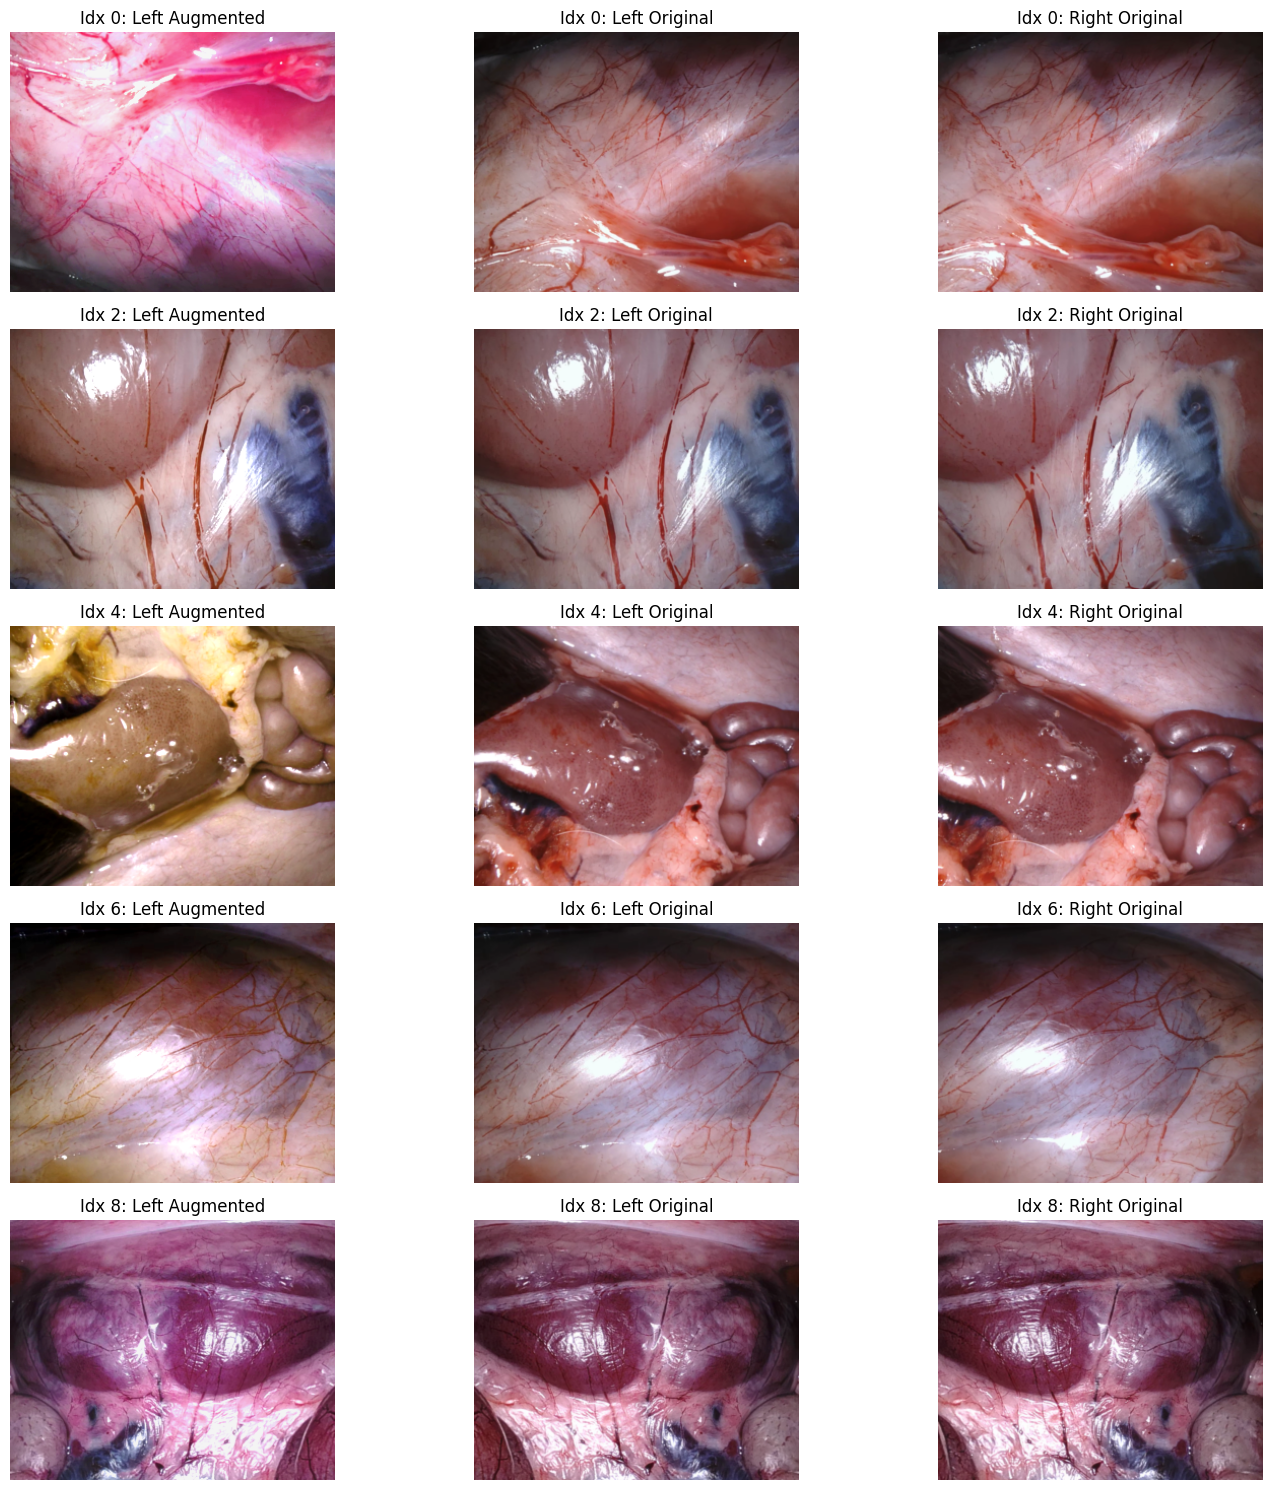

In [31]:
batch_size = left_aug.shape[0]
indices = [0, 2, 4, 6, 8]  # Replace with your desired indices
num_samples = len(indices)

plt.figure(figsize=(15, 3 * num_samples))

for i, idx in enumerate(indices):
    if idx >= batch_size:
        continue  # Skip if index is out of bounds

    left_aug_img = F.to_pil_image(left_aug[idx].cpu())
    left_orig_img = F.to_pil_image(left_tensor[idx].cpu())
    right_orig_img = F.to_pil_image(right_tensor[idx].cpu())

    plt.subplot(num_samples, 3, i*3 + 1)
    plt.imshow(left_aug_img)
    plt.title(f'Idx {idx}: Left Augmented')
    plt.axis('off')

    plt.subplot(num_samples, 3, i*3 + 2)
    plt.imshow(left_orig_img)
    plt.title(f'Idx {idx}: Left Original')
    plt.axis('off')

    plt.subplot(num_samples, 3, i*3 + 3)
    plt.imshow(right_orig_img)
    plt.title(f'Idx {idx}: Right Original')
    plt.axis('off')

plt.tight_layout()
plt.show()